<a href="https://colab.research.google.com/github/soyeunju/ESAA/blob/main/25-1/Assignments/0519_Week12_HM_DLWP_CNN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📊딥러닝 파이토치 교과서 ch 5.2

p.179~200

## 5.2 합성곱 신경망 맛보기

* fashion_mnist 데이터셋을 사용하여 합성곱 신경망을 직접 구현해보기
  * 데이터셋을 자세히 살펴보면 훈련 데이터(train_images)는 0에서 255 사이의 값을 갖는 28x28 크기의 넘파이 (Numpy) 배열이고, 레이블(정답) 데이터(train_labels)는 0에서 9까지 정수 값을 갖는 배열.
  * 28 x 28 픽셀의 이미지 7만 개로 구성됨.

In [2]:
# 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

In [3]:
# CPU 혹은 GPU 장치 확인
device = torch.device('mps' if torch.mps.is_available() else 'cpu')

In [4]:
device

device(type='cpu')

**GPU 사용**
* 일반적으로 하나의 GPU를 사용할 때 다음과 같은 코드 사용.

    ```
    import torch

    device = torch.device("mps" if torch.mps.is_available() else "cpu")

    model = Net()
    model.to(device)
    ```
* 다수의 GPU를 사용할 때 다음과 같은 코드 사용.
    ```
    device = torch.device("mps" if torch.mps.is_available() else "cpu")

    model = Net()
    if torch.mps.device_count() > 1:
        model = nn.DataParallel(net)
    model.to(device)
    ```
    * 배치 크기(batch size)가 알아서 각 GPU로 분배되는 방식으로 작동되기 때문에 GPU 수만큼 배치 크기도 늘려주어야 함.

In [5]:
# fashion_mnist 데이터셋 내려받기
train_dataset = torchvision.datasets.FashionMNIST("FashionMNIST/", download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("FashionMNIST/", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

* transform : 이미지를 tensor(0~1)로 변경.

In [6]:
# fashion_mnist 데이터를 데이터로더에 전달
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100)

* `torch.utils.data.DataLoader()` 를 사용하여 원하는 크기의 배치 단위로 불러오거나 / 무작위로 섞이도록 할 수 있음(`shuffle = True`)
* `torch.utils.data.DataLoader(train_dataset, batch_size = 100)`
    * 첫 번째 파라미터 : 불러올 데이터셋
    * 두 번째 파라미터 : 배치 사이즈

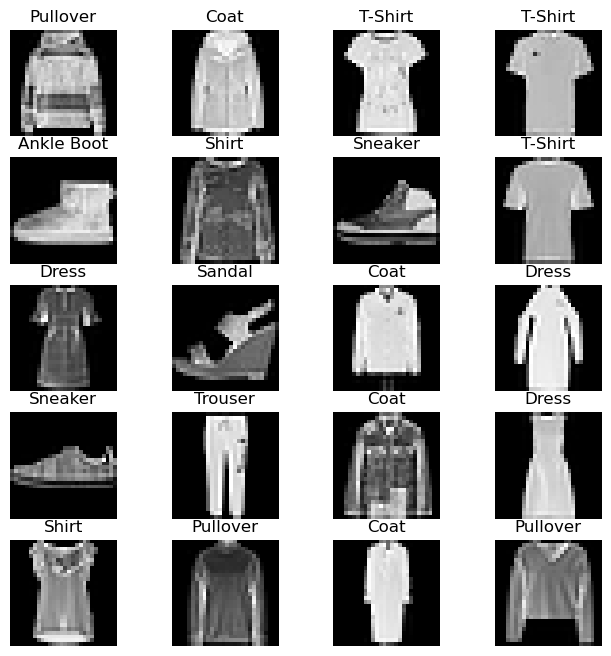

In [ ]:
# 분류에 사용될 클래스 정의
labels_map = {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4:'Coat',
              5: 'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'} # 10개의 클래스

fig = plt.figure(figsize = (8,8)) # 출력할 이미지의 가로세로 길이로 단위는 inch
columns = 4;
rows = 5;

for i in range(1, columns*rows + 1):
    img_xy = np.random.randint(len(train_dataset)); # 이산형 분포를 갖는 데이터에서 무작위 표본을 추출
    img = train_dataset[img_xy][0][0,:,:] # img_xy 번째 사진의 첫 번째 채널 선택. 2차원 형태로 잘라낸 이미지. 텐서의 shape는 (1, 28, 28)
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap = 'gray')
plt.show() # 20개의 이미지를 시각적으로 표현

In [ ]:
len(train_dataset)

60000

np.random : 무작위로 데이터를 생성할 때 사용
* `np.random.randint()` : 이산형 분포를 갖는 데이터에서 무작위 표본을 추출할 때 사용
* `np.random.rand()` : 0~1 사이의 정규표준분포 난수 추출
* `np.random.randn()` : 평균 0, 표준편가 1인 가우시안 정규분포에서 난수 추출

In [ ]:
# 심층 신경망 모델 생성
class FashionDNN(nn.Module): # 클래스 형태는 항상 nn.Module을 상속 받음
    def __init__(self): # __init__은 객체가 갖는 속성 값 초기화하며 객체가 생성될 때 자동으로 호출
        super(FashionDNN, self).__init__() # super~ 는 nn.Module 클래스를 상속받겠다.
        self.fc1 = nn.Linear(in_features = 784, out_features = 256) # Linear는 단순 선형 회귀
        self.drop = nn.Dropout(0.25) # torch.nn.Dropout(p)는 p만큼의 비율로 텐서의 값이 0이 되고, 0이 되지 않는 값들은 기존 값에 (1/(1-p))만큼 곱해져 커짐.
        self.fc2 = nn.Linear(in_features = 256, out_features = 128)
        self.fc3 = nn.Linear(in_features = 128, out_features = 10)

    def forward(self, input_data): # forward(): 모델이 학습 데이터를 입력받아서 순전파 연산(x로부터 예측된 y를 얻는 것)을 진행하는 함수
        out = input_data.view(-1,784) # .view : 넘파이의 reshape와 같음. 3차원 -> 2차원
        out = F.relu(self.fc1(out)) ###
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

**클래스**
* 클래스는 함수뿐만 아니라 관련된 변수까지도 한꺼번에 묶어서 관리하고 재사용할 수 있게 해 주는 것.
  ```
  class Calc:
      def __init__(self): ------ 객체를 생성할 때 호출하면 실행되는 초기화 함수
      self.result =0
      def add(self, num1, num2):
          self.result = num1 + num2
          return self.result
  obj1 =Calc()
  obj2 =Calc()
  
  print(obj1.add( 1, 2))
  print(obj1.add( 2, 3))
```
* 두 개의 객체는 독립적으로 연산. 코드가 간결해짐

**활성화 함수를 지정**
* `F.relu()`: `forward()` 함수에서 정의
* `nn.ReLU()`: `__init__()` 함수에서 정의

| 구분        | nn.xx (객체지향 방식)                                                | nn.functional.xx (함수 기반)                                                        |
|-------------|------------------------------------------------------|--------------------------------------------------------------------------|
| 형태        | nn.Conv2d: 클래스<br>nn.Module 클래스를 상속받아 사용 | nn.functional.conv2d: 함수<br>def function(input)으로 정의된 순수한 함수 |
| 호출 방법   | 먼저 하이퍼파라미터를 전달한 후 함수 호출을 통해 데이터 전달 | 함수를 호출할 때 하이퍼파라미터, 데이터를 함께 전달                     |
| 위치        | nn.Sequential 내에 위치                               | nn.Sequential에 위치할 수 없음                                          |
| 파라미터    | 파라미터를 새로 정의할 필요 없음. 내부적으로 가중치(W), 편향(b) 등의 파라미터를 알아서 관리                     | 가중치를 수동으로 전달해야 하며, 매번 자체 가중치를 정의                |


* nn.xx
```
import torch
import torch.nn as nn
inputs = torch.randn(64, 3, 244, 244)
conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
outputs = conv(inputs)
layer = nn.Conv2d( 1, 1, 3)
```
* nn.functional.xx
```
import torch.nn.functional as F
inputs = torch.randn(64, 3, 244, 244)
weight = torch.randn(64, 3, 3, 3)
bias = torch.randn(64)
outputs = F.conv2d(inputs, weight, bias, padding=1)
```

In [ ]:
# 신경망에서 필요한 파라미터 정의
learning_rate = 0.01
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss() # 분류 문제에서 사용하는 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# 심층 신경망을 이용한 모델 학습
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epochs in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) # 모델이 데이터를 처리하기 위해서는 모델과 데이터가 동일한 장치 (CPU 또는 GPU)에 있어야 함.

        train = Variable(images.view(100,1,28,28)) # 최근 업데이트 버전에서는 Variable 활용 ❌. torch.tensor(.., requires_grad=True)로 자동 미분 가능
        labels = Variable(labels)
        outputs = model(train) # 학습 데이터를 모델에 적용
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count%50): # count가 50으로 나누어 떨어지는 경우
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(outputs)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count%500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data,accuracy))

Iteration: 500, Loss: 0.6829047203063965, Accuracy: 80.94000244140625%
Iteration: 1000, Loss: 0.6949700117111206, Accuracy: 82.23999786376953%
Iteration: 1500, Loss: 0.47455844283103943, Accuracy: 80.77999877929688%
Iteration: 2000, Loss: 0.434455007314682, Accuracy: 82.08999633789062%
Iteration: 2500, Loss: 0.3246341347694397, Accuracy: 82.45999908447266%
Iteration: 3000, Loss: 0.37684017419815063, Accuracy: 83.30000305175781%


In [ ]:
# train_loader 데이터는 어떻게 생겼는지 살펴보자
for batch in train_loader:
    print(type(batch))
    print(len(batch))   # 보통 (입력, 타깃)
    print(batch[0].shape)  # 입력 데이터
    print(batch[1].shape)  # 레이블
    break

<class 'list'>
2
torch.Size([100, 1, 28, 28])
torch.Size([100])


* 정확도는 사실 분류 모델을 평가하는 데 좋은 성능 지표가 아님. 모든 클래스에 대한 예측력이 높은지 알 수 없기 때문

In [6]:
# 합성곱 네트워크 생성
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential( # nn.Seqeuntial 사용하면 __ init __()에서 사용할 네트워크 모델을 정의.
                                     # forward() 함수에서 구현될 순전파를 계층(layer) 형태로 좀 더 가독성이 뛰어난 코드로 작성
        nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding = 1),
            # kernel_size: 커널 크기(필터). 입력 데이터를 스트라이드 간격으로 순회하면서 합성곱을 계산
            # padding: 출력 크기를 조정하기 위해 입력 데이터 주위에 0을 채움
        nn.BatchNorm2d(32),
            # BatchNorm2d: 학습 과정에서 각 배치 단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용하여 정규화하는 것을 의미
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
            # MaxPoo12d: 이미지 크기를 축소시키는 용도로 사용. 합성곱층의 출력 데이터를 입력으로 받아서 출력 데이터(activation map)의 크기를 줄이거나 데이터를 강조하는 용도
            # max pooling / average pooling / min pooling
            # nn.MaxPool2d(kernel_size = 2, stride = 2)
                # kernel_size: mXn 행렬로 구성된 가중치
                # stride: 입력 데이터에 커널(필터)을 적용할 때 이동할 간격을 의미하는데, 스트라이드 값이 커지면 출력 크기는 작아짐.
        )

        self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
        )

        # CNN 구조에서 Conv2d, MaxPool2d→ Linear (완전 연결층)으로 넘어갈 때 차원이 다르기 때문에 주의. 1차원으로 변경
        self.fc1 = nn.Linear(in_features = 64*6*6, out_features = 600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features = 600, out_features = 120)
        self.fc3 = nn.Linear(in_features = 120, out_features = 10) # 마지막 out_features는 클래스 개수를 의미

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # out.size(0)은 배치 사이즈를 의미.
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

**Conv2d 계층에서 출력 크기 구하는 공식**

* 출력 크기 = $(W-F+2P)/S+1$
    * $W$: 입력 데이터의 크기(input_volume_size)
    * $F$: 커널 크기(kernel_size)
    * $P$: 패딩 크기(padding_size)
    * $S$: 스트라이드(strides)
* ex. nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
    * 출력 크기 : (28 - 3 + (2*1))/1+1=28
    * [32,28,28] : 이때 32는 out_channels.

**MaxPool2d 계층에서의 출력 크기 구하는 공식**
* 출력 크기 = $IF/F$
    * $IF$: 입력 필터의 크기 (input_filter_size 또한 바로 앞의 Conv2d의 출력 크기)
    * $F$: 커널 크기 (kernel_size)
* ex. nn.MaxPoo12d( kernel_size=2, stride=2)
    * 출력 크기 : 784/2 =392
    * [32,392,392]

In [7]:
# 합성곱 네트워크를 위한 파라미터 정의
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [9]:
# 모델 학습 및 성능 평가
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)

      train = Variable(images.view(100, 1, 28, 28))
      labels = Variable(labels)

      outputs = model(train)
      loss = critertion(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      count += 1

      if not (count % 50):
        total = 0
        correct = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels_list.append(labels)
            test = Variable(images.view(100, 1, 28, 28))
            outputs = model(test)
            predictions = torch.max(outputs, 1)[1].to(device)
            predictions_list.append(predictions)
            correct += (predictions == labels).sum()
            total += len(labels)

        accuracy = correct * 100 / total
        loss_list.append(loss.data)
        iteration_list.append(count)
        accuracy_list.append(accuracy)

      if not (count % 500):
        print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.4778556823730469, Accuracy: 87.69000244140625%
Iteration: 1000, Loss: 0.35716721415519714, Accuracy: 88.2300033569336%
Iteration: 1500, Loss: 0.3161049485206604, Accuracy: 89.08000183105469%
Iteration: 2000, Loss: 0.269358366727829, Accuracy: 88.27999877929688%
Iteration: 2500, Loss: 0.12255150824785233, Accuracy: 89.81999969482422%
Iteration: 3000, Loss: 0.22730684280395508, Accuracy: 89.23999786376953%
